In [1]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
def GConv(features):
    import tensorflow as tf
    features_img,features_mask = tf.split(features, 2, 3)
    features_img = Activation('elu')(features_img)
    features_mask = Activation('sigmoid')(features_mask)
    re_img = tf.multiply(features_img,features_mask)
    return re_img

In [3]:
shape = (64, 64, 2)

input_img = Input(shape=(shape[0], shape[1], shape[2],))
img1 = Conv2D(32, kernel_size=(7,7), strides=(2,2),padding='same')(input_img)
img1 = Lambda(GConv)(img1)#32

img2 = Conv2D(64, kernel_size=(5,5), strides=(2,2),padding='same')(img1)
img2 = Lambda(GConv)(img2)
img2 = BatchNormalization()(img2)
img2 = Activation('relu')(img2)#16

img3 = Conv2D(64, kernel_size=(3,3), strides=(2,2),padding='same')(img2)
img3 = Lambda(GConv)(img3)
img3 = BatchNormalization()(img3)
img3 = Activation('relu')(img3)#8

img4 = Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2),padding='same')(img3)
img4 = Lambda(GConv)(img4)
img4 = BatchNormalization()(img4)
img4 = LeakyReLU(alpha=0.2)(img4)#16

confuse1 = concatenate([img2,img4])
img5 = Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2),padding='same')(confuse1)
img5 = Lambda(GConv)(img5)
img5 = BatchNormalization()(img5)
img5 = LeakyReLU(alpha=0.2)(img5)#32

confuse2 = concatenate([img1,img5])
img6 = Conv2DTranspose(32, kernel_size=(7,7), strides=(2,2),padding='same')(confuse2)
img6 = Lambda(GConv)(img6)
img6 = BatchNormalization()(img6)
img6 = LeakyReLU(alpha=0.2)(img6)#64

confuse3 = concatenate([input_img,img6])
img7 = Conv2D(2, kernel_size=(3,3), strides=(1,1),padding='same')(confuse3)
out_img = Lambda(GConv)(img7)

2022-10-28 16:56:51.815209: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 16:56:52.481856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22312 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:db:00.0, compute capability: 8.6


In [4]:
Coarse_reconstruction = Model(inputs=input_img, outputs=out_img)
Coarse_reconstruction.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
Coarse_reconstruction.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   3168        ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   25664       ['lambda[0][0]']                 
                                                                                              

In [5]:
import numpy as np

IGS_data = np.load('IGS_data11_17.npy')
MIT_data = np.load('miss data/MIT_miss.npy')

stock = np.abs(IGS_data)<=999
stock1 = np.abs(MIT_data)<=999
stock2 = np.abs(MIT_data)>999
IGS_data = IGS_data  * stock 
MIT_data = MIT_data * stock * stock1

IGS_data = IGS_data/100
MIT_data = MIT_data/100
print(IGS_data.shape)
print(MIT_data.shape)

(61368, 64, 64, 1)
(61368, 64, 64, 1)


In [6]:
#载入门控卷积的掩码，这里的IGS-TEC只是用来预训练的数据
IGS_0 = IGS_data * stock1
mask = np.ones((61368, 64, 64, 1))*stock2 #掩码的形状是MIT-TEC的缺失部分

IGS_nonzeros = IGS_0[IGS_0 != 0 ]
IGS_mean = np.mean(IGS_nonzeros)
IGS_1 = IGS_0 + 0.5 * mask

IGS_mask = np.concatenate((IGS_1,mask),axis = -1)

In [7]:
#MIT-TEC同样加上掩码，作为预测数据
MIT_nonzeros = MIT_data[MIT_data != 0 ]
MIT_mean = np.mean(MIT_nonzeros)
re_MIT = MIT_data + 0.5 * mask

MIT_mask = np.concatenate((re_MIT,mask),axis = -1)

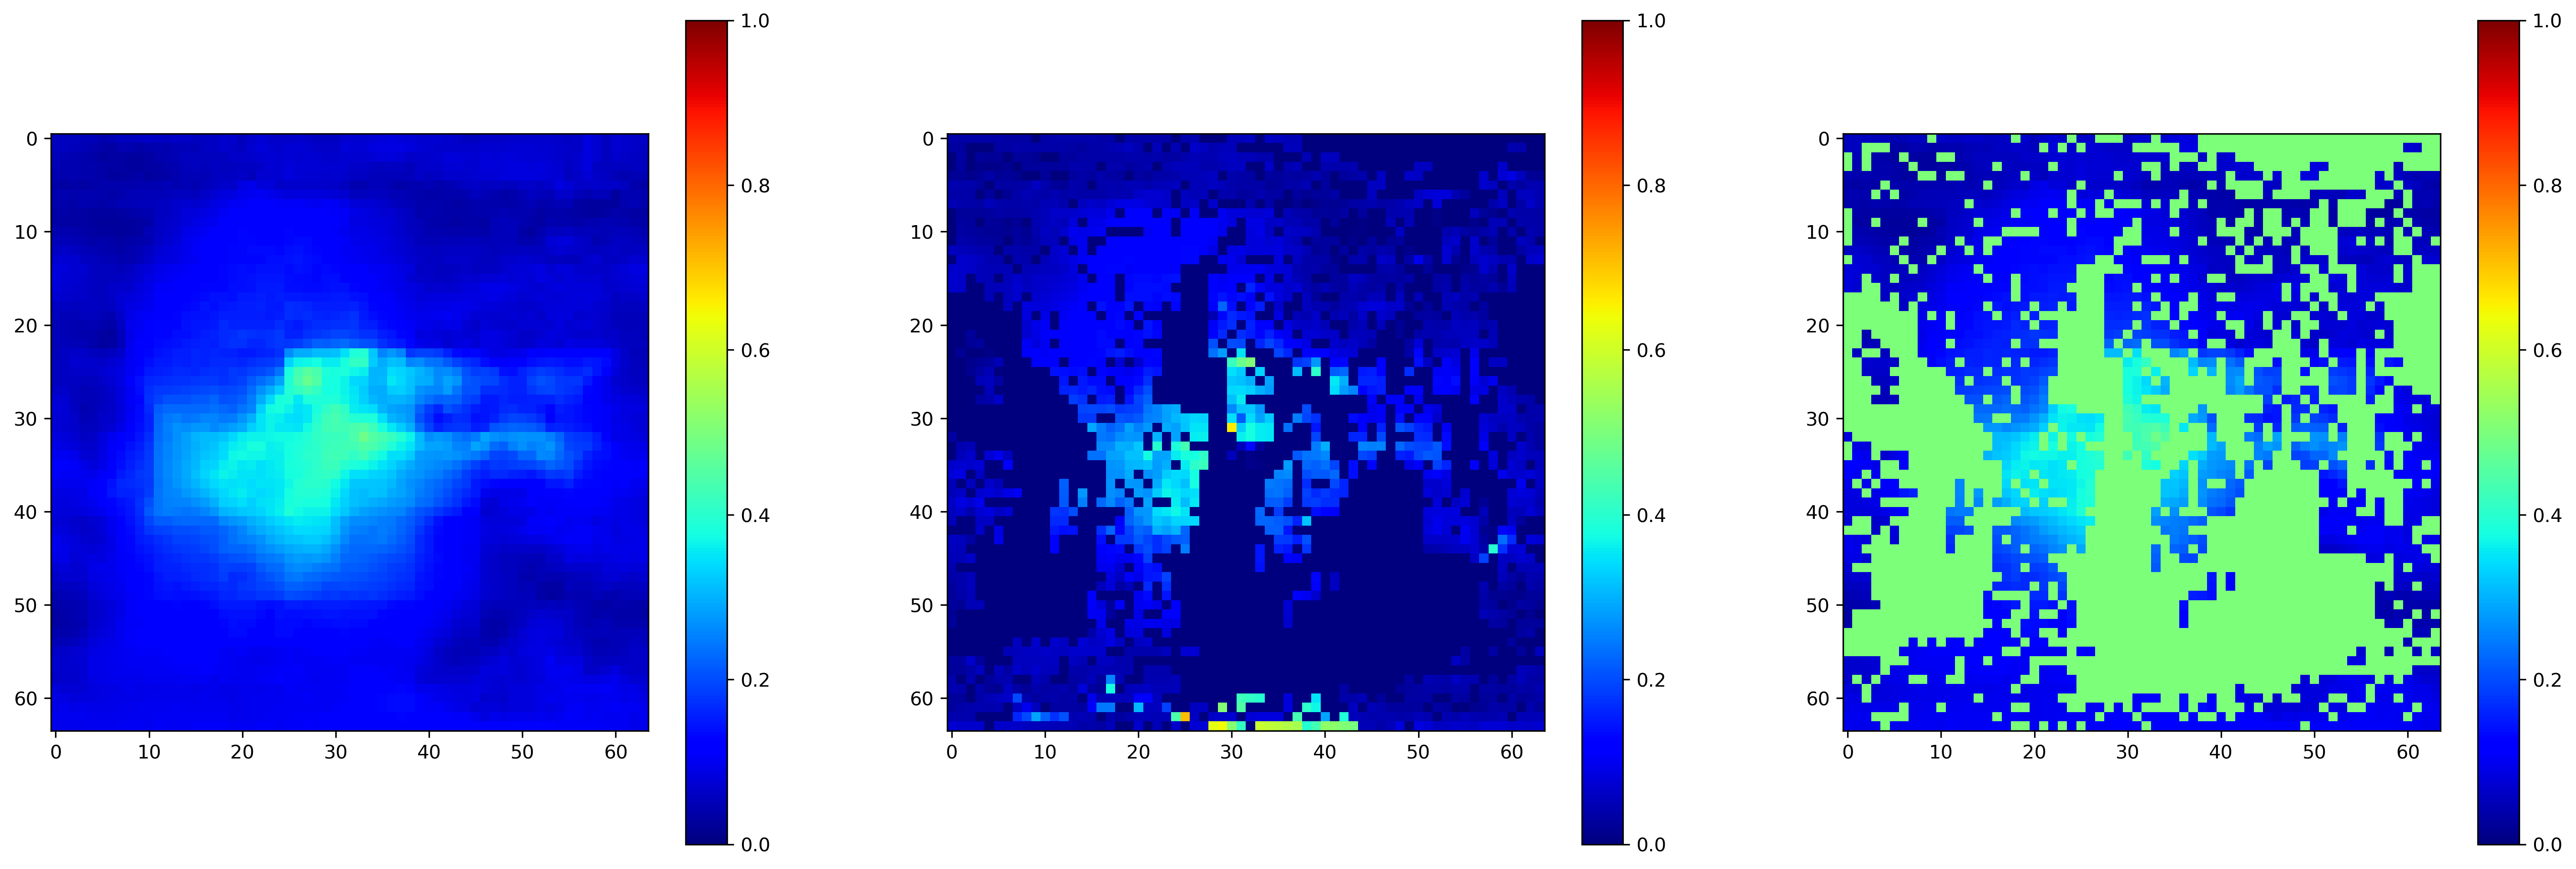

In [8]:
import matplotlib
import matplotlib.pyplot as plt

n = 1000
plt.figure(dpi=300,figsize=(24,8))
plt.subplot(1,3,1)
plt.imshow(IGS_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(MIT_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(IGS_1[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.show()

In [27]:
Coarse_reconstruction.fit(IGS_mask, IGS_data, 
                epochs=10,
                batch_size=500,verbose=1,shuffle=True,validation_split = 0.2)

Epoch 1/10
99/99 [==============================] - 9s 90ms/step - loss: 1.4056e-04 - mae: 0.0070 - val_loss: 1.4007e-04 - val_mae: 0.0066
Epoch 2/10
99/99 [==============================] - 6s 64ms/step - loss: 1.4543e-04 - mae: 0.0070 - val_loss: 1.4884e-04 - val_mae: 0.0069
Epoch 3/10
99/99 [==============================] - 7s 70ms/step - loss: 1.4586e-04 - mae: 0.0071 - val_loss: 4.8057e-04 - val_mae: 0.0119
Epoch 4/10
99/99 [==============================] - 7s 66ms/step - loss: 1.4783e-04 - mae: 0.0072 - val_loss: 2.9116e-04 - val_mae: 0.0089
Epoch 5/10
99/99 [==============================] - 6s 65ms/step - loss: 1.4406e-04 - mae: 0.0071 - val_loss: 4.6790e-05 - val_mae: 0.0043
Epoch 6/10
99/99 [==============================] - 7s 68ms/step - loss: 1.3967e-04 - mae: 0.0070 - val_loss: 1.6809e-04 - val_mae: 0.0071
Epoch 7/10
99/99 [==============================] - 7s 67ms/step - loss: 1.4294e-04 - mae: 0.0070 - val_loss: 2.5365e-04 - val_mae: 0.0094
Epoch 8/10
99/99 [=========

In [28]:
pre_mit = Coarse_reconstruction.predict(MIT_mask)
pre_igs = Coarse_reconstruction.predict(IGS_mask)
#pre_mit才是我们想要的预测数据，pre_igs只是为了查看修复程度
#训练次数不应过多，会产生过拟合

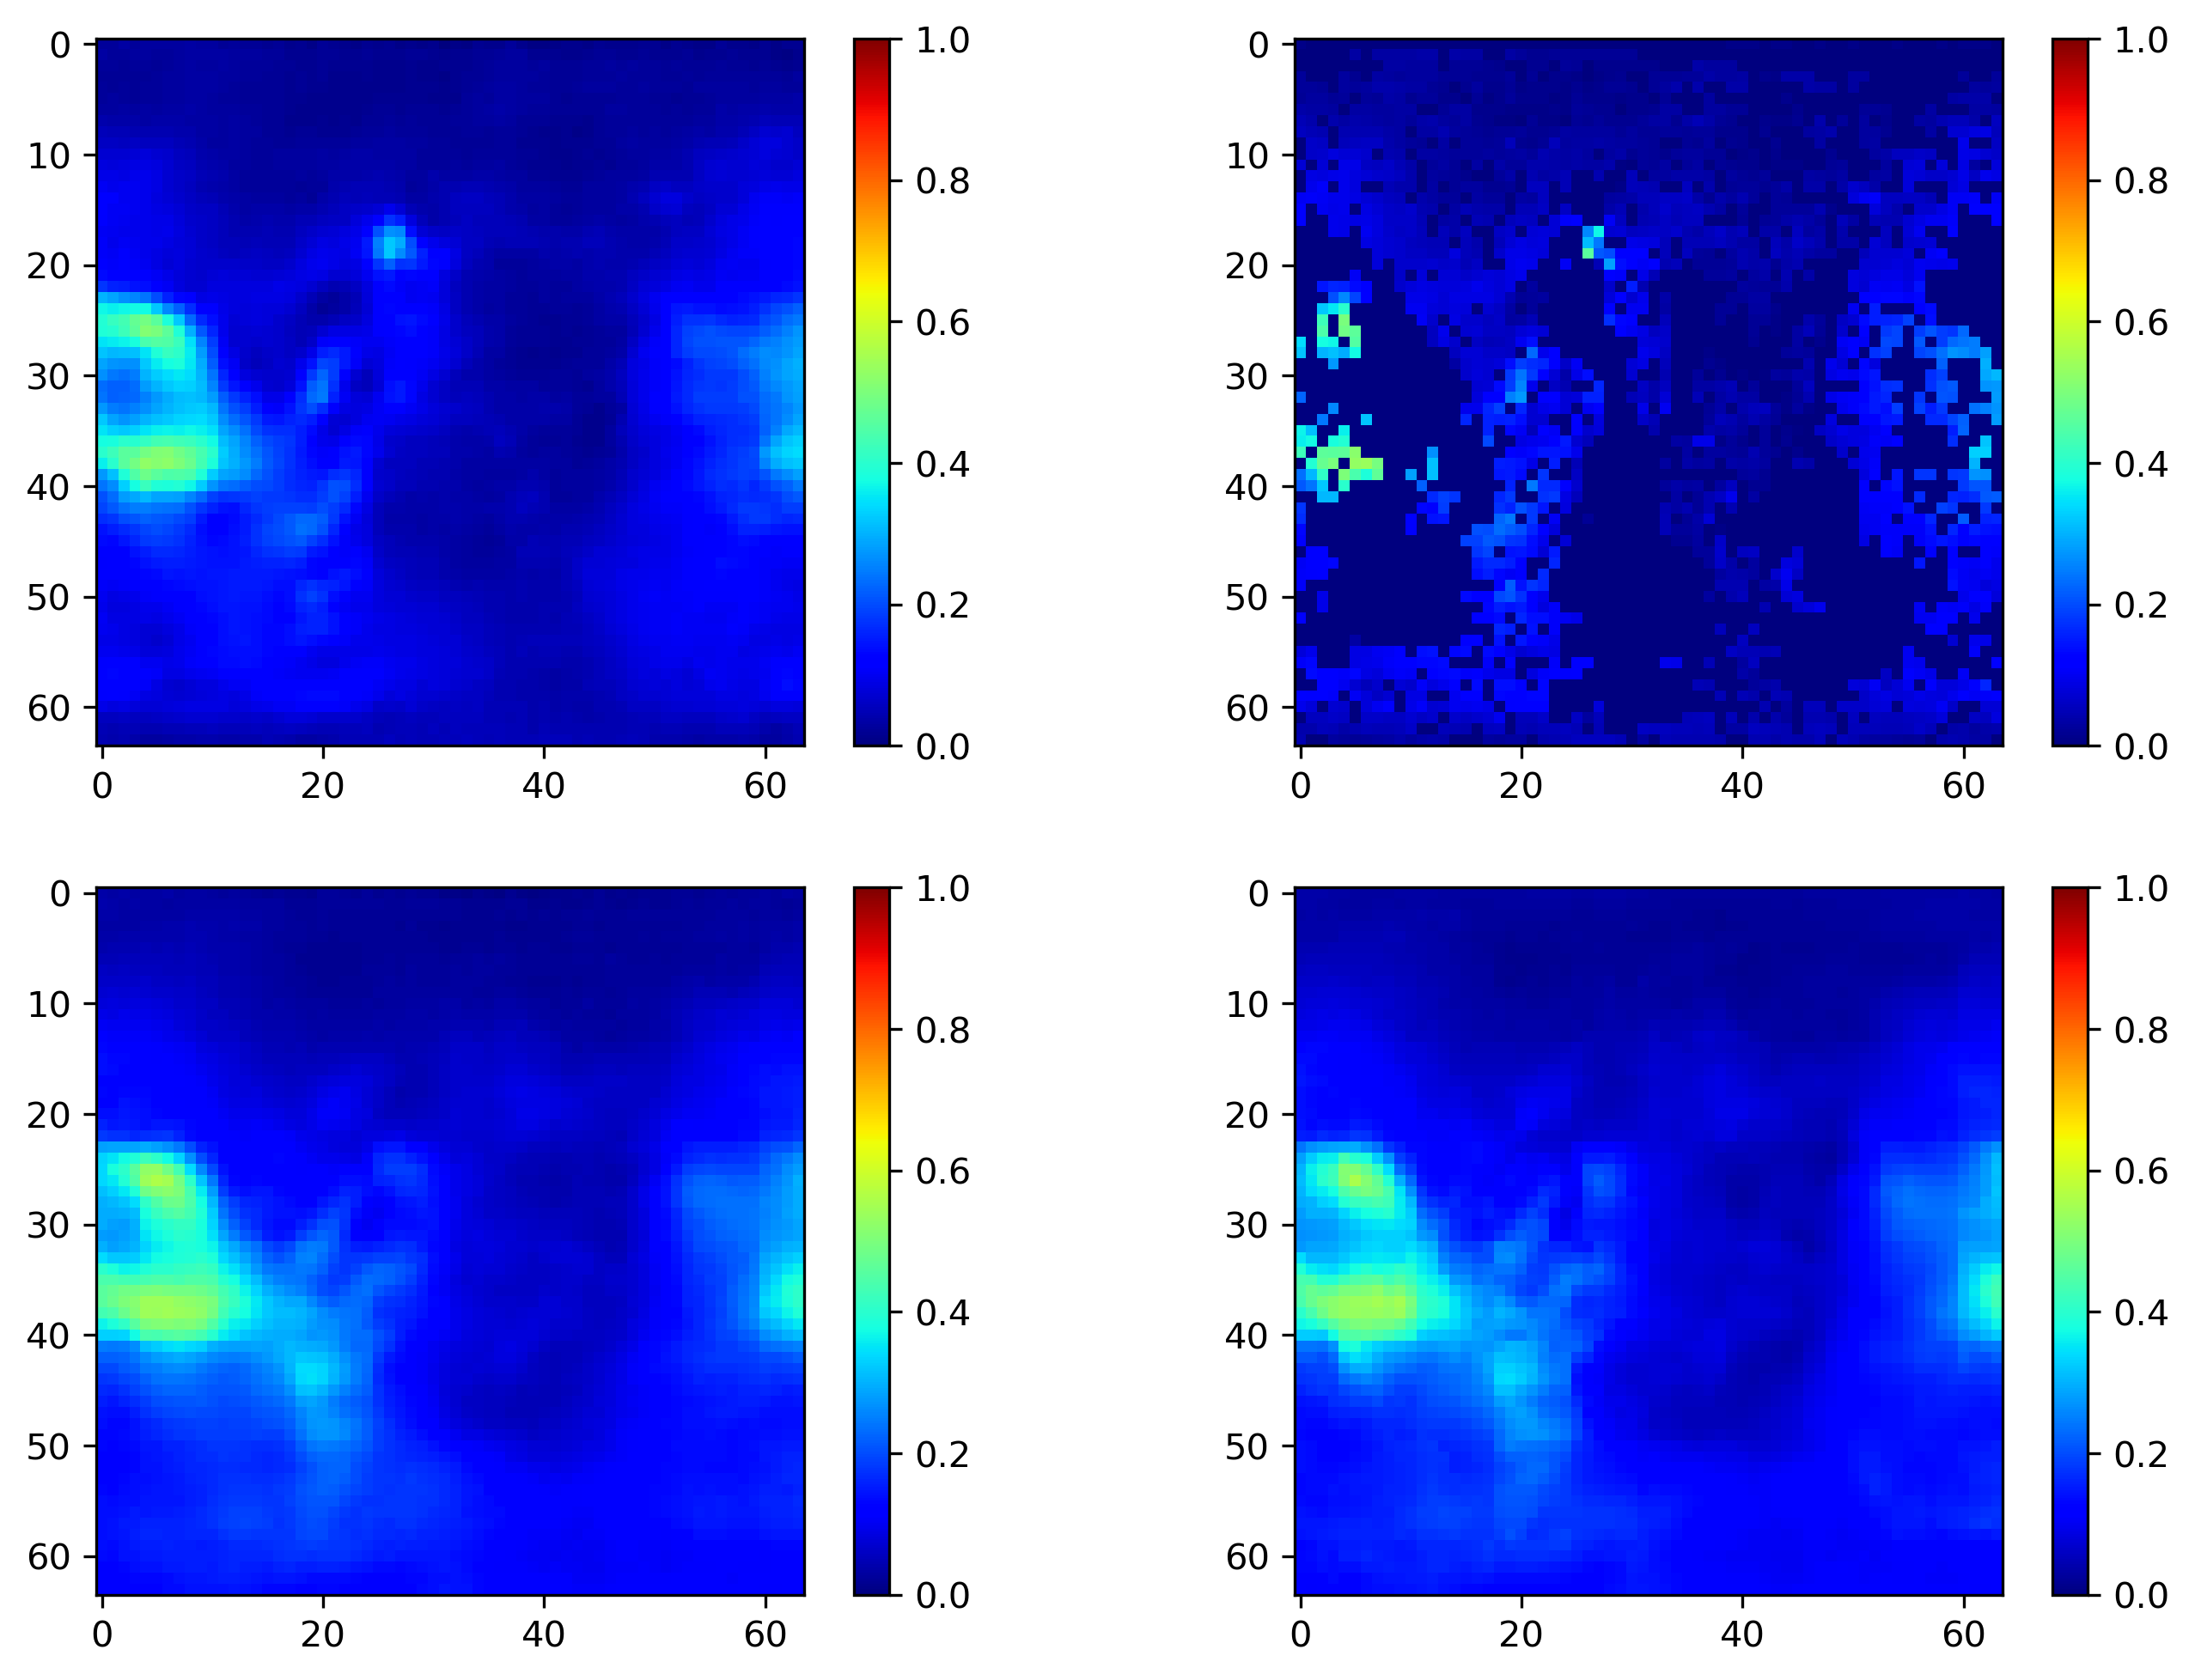

In [29]:
plt.figure(dpi=300,figsize=(11,8))
n = 0  #随便取了一张图
plt.subplot(221)
plt.imshow(pre_mit[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(222)
plt.imshow(MIT_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(223)
plt.imshow(pre_igs[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.subplot(224)
plt.imshow(IGS_data[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.colorbar()

plt.show()

(-0.5, 63.5, 63.5, -0.5)

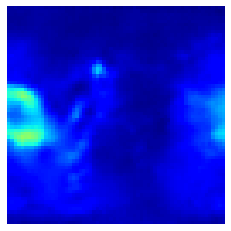

In [30]:
plt.imshow(pre_mit[n,:,:,0], cmap='jet',vmax=1,vmin=0)
plt.axis('off')

In [31]:
# Coarse_reconstruction.save('GConv.h5')
# #这行代码是模型的保存，文件夹中的GConv.h5是已经训练好的文件

In [32]:
# np.save('pre_MIT',pre_mit)